In [53]:
import numpy as np
#list important:
# k_create,
# one_hot_sim, k_exp_horiz

#Set Parameters
n = 7
k_o = 0.4
k_s = 1
alpha = 1 - (2 * (k_o/k_s))
alpha_prime = k_o/k_s
p = 5
q = 2
c_var = 0
lamb_val = np.arccosh((1+c_var)/(1-alpha))

K = {}
K_exp = {}
A = {}

arr_len = n-1
dual_len = (n-1) * 2
dual_len_exp = (n-1)*2 + 2
a = np.zeros(dual_len)
a_exp = np.zeros(dual_len_exp)
b = np.zeros(arr_len)
b_bar = np.zeros(arr_len)
c = np.zeros(1)
c_bar = np.zeros(1) 

def check_variables():
    print('n: ', n)
    print('alpha: ', alpha)
    print('k_s: ', k_s)
    print('k_o: ', k_o)
    print('alpha_prime: ', alpha_prime)
    print('c_var', c_var)
    print('lamb_val', lamb_val)
    print('a', a)
    print('a_exp', a_exp)
    print('b', b)
    print('c', c)


In [54]:
#K matrix without exceptions
    # return_k = false -> returns offset diagonal  
def tridiag(n):
    arr_len = n-1
    diag_len = arr_len-1
    B = np.diag(np.ones((diag_len)), k=1) + np.diag(np.ones((diag_len)), k=-1)
    return B        

def k_create(n, alpha_prime):
    arr_len = n-1
    A = np.identity(arr_len)
    D = A
    B = alpha_prime*tridiag(n)
    C = B
    E = np.block([[A,B],[B,A]])
    return E

def y_create(n):
    A = np.ones(n-1)
    B = A * -1
    D = np.concatenate([A, B])
    return D

def a_create(n, alpha_prime):
    K = k_create(n, alpha_prime)
    y = y_create(n)
    a = np.linalg.solve(K, y)
    return a

In [55]:
K = k_create(n,alpha_prime)
print('K', '\n', K)
print('det:', np.linalg.det(K))

y = y_create(n)
a = a_create(n, alpha_prime)

K 
 [[1.  0.  0.  0.  0.  0.  0.  0.4 0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.4 0.  0.4 0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.4 0.  0.4 0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.4 0.  0.4 0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0.4 0.  0.4]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.4 0. ]
 [0.  0.4 0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.4 0.  0.4 0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.4 0.  0.4 0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.4 0.  0.4 0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.4 0.  0.4 0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.4 0.  0.  0.  0.  0.  0.  1. ]]
det: 0.12215304601599994


In [56]:
def test_Ka_y():
    assert np.allclose(K@a, y), "if not equal"
    print('test: K@a = y', '\n')

test_Ka_y()

test: K@a = y 



In [57]:
#creates a vector for exceptions (only works for exception cases!)
def e_i(n, i):
    len_arr = n-1
    array_pos = i-1     #(-1 to normalize), p and q refer to normal indices (from 1 to len_arr)
    arr = np.zeros(len_arr)
    if i > 0 and i < n: #if outside, k_o excluded from similarity matrix e.g. AE exception for n=5
        arr[array_pos] = 1 
    return arr

#sides matrix in k_exp representing exceptions
def k_exp_horiz(n, p, q, alpha_prime):
    A = e_i(n, p) + e_i(n, q-1)
    B = e_i(n, q) + e_i(n, p-1)
    C = e_i(n, p-1) + e_i(n, q)
    D = e_i(n, q-1) + e_i(n, p)
    E = alpha_prime * np.block([[A,C],[B,D]])
    return E

def k_create_excep(n, p, q, alpha_prime):
    K = k_create(n, alpha_prime)
    E_1 = k_exp_horiz(n, p, q, alpha_prime)
    E_2 = E_1.transpose()
    E_3 = np.identity(2) #2 since there's only 2 columns for exceptions
    
    W = np.concatenate([K, E_1])
    X = np.concatenate([E_2, E_3])
    Z = np.concatenate([W, X], 1)
    return Z

def y_create_exp(n):
    A = np.ones(n-1)
    B = A * -1
    C = np.array([1, -1])
    D = np.concatenate([A, B, C])
    return D

def a_exp_create(n, p, q, alpha_prime):
    K_exp = k_create_excep(n, p, q, alpha_prime)
    y_exp = y_create_exp(n)
    a_exp = np.linalg.solve(K_exp, y_exp)
    return a_exp


In [58]:
K_exp = k_create_excep(n, p, q, alpha_prime)
print('K_exp', '\n',K_exp)
np.linalg.det(K_exp)
y_exp = y_create_exp(n)
a_exp = a_exp_create(n, p, q, alpha_prime)

print('y', y)
print('K@a', K@a, '\n')

print('y_exp', y_exp)
print('K_exp@a_exp', K_exp@a_exp, '\n')

def test_Ka_y_exp():
    assert np.allclose(K_exp@a_exp, y_exp), "if not equal"
    print('test: K_exp@a_exp = y_exp', '\n')

test_Ka_y_exp()


K_exp 
 [[1.  0.  0.  0.  0.  0.  0.  0.4 0.  0.  0.  0.  0.4 0. ]
 [0.  1.  0.  0.  0.  0.  0.4 0.  0.4 0.  0.  0.  0.  0.4]
 [0.  0.  1.  0.  0.  0.  0.  0.4 0.  0.4 0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.4 0.  0.4 0.  0.  0.4]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0.4 0.  0.4 0.4 0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.4 0.  0.  0. ]
 [0.  0.4 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.4]
 [0.4 0.  0.4 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.4 0. ]
 [0.  0.4 0.  0.4 0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.4 0.  0.4 0.  0.  0.  0.  1.  0.  0.  0.4 0. ]
 [0.  0.  0.  0.4 0.  0.4 0.  0.  0.  0.  1.  0.  0.  0.4]
 [0.  0.  0.  0.  0.4 0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.4 0.  0.  0.  0.4 0.  0.  0.4 0.  0.4 0.  0.  1.  0. ]
 [0.  0.4 0.  0.4 0.  0.  0.4 0.  0.  0.  0.4 0.  0.  1. ]]
y [ 1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.]
K@a [ 1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.] 

y_exp [ 1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1

In [59]:
# Create a dictionary with keys generated using the index and values from the array
def create_bc(n,p,q,alpha_prime):
    a_exp = a_exp_create(n,p,q,alpha_prime)
    num_coeff = n-1
    b = {i: a_exp[i-1] for i in range(1, num_coeff + 1)}
    b_bar = {i: a_exp[i-1+n-1] for i in range(1, num_coeff + 1)}
    c = {1: a_exp[2 * num_coeff]}
    c_bar = {1: a_exp[2 * num_coeff + 1]}
    return b, b_bar, c, c_bar

def create_bc_arrays(n,p,q,alpha_prime):
    b, b_bar, c, c_bar = create_bc(n,p,q,alpha_prime)
    b_array = dict_to_array(b)
    b_bar_array = dict_to_array(b_bar)
    c_array = dict_to_array(c)
    c_bar_array = dict_to_array(c_bar)
    return b_array, b_bar_array, c_array, c_bar_array

def get_b(i):
    b, b_bar, c, c_bar = create_bc(n,p,q,alpha_prime)
    if i < 1 or i >= n:
        return 0
    else:
        return b[i]

#turns dictionary to array for testing
def dict_to_array(dict_arr):
    arr = np.zeros(len(dict_arr))
    for i in range(1, len(dict_arr) + 1):
       arr[i-1] = dict_arr[i]  
    return arr        

In [60]:
b, b_bar, c, c_bar = create_bc(n,p,q,alpha_prime)
b_array, b_bar_array, c_array, c_bar_array = create_bc_arrays(n,p,q,alpha_prime)

verif = True
for i in range(0, n-1):
    if a_exp[i] != b[i+1]:
        verif = False
    if a_exp[i+n-1] != b_bar[i+1]:
        verif = False    
    if a_exp[(2*n-2)] != c[1]:
        verif = False
    if a_exp[(2*n-1)] != c_bar[1]:
        verif = False
print('create_bc is correct')

create_bc is correct


In [61]:
A = tridiag(n)
B = np.linalg.inv(np.identity(n-1) - (A*alpha_prime))


In [62]:
#test B
def B_ij_analytical(i, j):
    num = np.cosh((n-(np.abs(j-i))) * lamb_val) - np.cosh((n-i-j)*lamb_val)
    denom = (1-alpha) * np.sinh(lamb_val) * np.sinh(n * lamb_val)
    return num/denom

def B_ij_analytical_2(i,j):
    num = np.sinh( (n - (max(i,j))) * lamb_val) * np.sinh( (n - (min(i,j))) * lamb_val)
    denom = np.sinh(lamb_val) * np.sinh(n * lamb_val)
    return num/denom

def test_B_ij():
    for i in range (1, n):
        i_ind = i-1
        for j in range (1, n):
            j_ind = j-1
            assert np.isclose( B_ij_analytical(i,j), B[i_ind][j_ind], B_ij_analytical_2(i,j))
    print('B_ij analytic expression verified')
    print(B)

def B_ij(i,j):
    i_ind = i-1
    j_ind = j-1
    if i < 1 or j < 1 or i > n or j > n:
        return 0
    else: 
        return B[i_ind][j_ind]



In [63]:
test_B_ij()

B_ij analytic expression verified
[[1.2497711  0.62442776 0.3112983  0.15381798 0.07324666 0.02929866]
 [0.62442776 1.5610694  0.77824574 0.38454496 0.18311665 0.07324666]
 [0.3112983  0.77824574 1.63431606 0.80754441 0.38454496 0.15381798]
 [0.15381798 0.38454496 0.80754441 1.63431606 0.77824574 0.3112983 ]
 [0.07324666 0.18311665 0.38454496 0.77824574 1.5610694  0.62442776]
 [0.02929866 0.07324666 0.15381798 0.3112983  0.62442776 1.2497711 ]]


In [64]:
# For testing, we assume all variables of n, etc. are set at the beginning  
# These are:
# - n, alpha_prime, p, q, c

In [65]:
#test analytical solutions for b and c

def b_mult():
    A = tridiag(n)
    B = np.linalg.inv(np.identity(n-1) - (A*alpha_prime))

    K_mult = np.ones(n-1) - (c[1]*alpha_prime*(e_i(n, p) + e_i(n, q-1) - e_i(n, p-1) - e_i(n, q)))
    b_exp_analytical = B @ K_mult
    return b_exp_analytical

def test_b_mult():
    b_exp_analytical = b_mult()
    b_array = dict_to_array(b)
    assert np.allclose(b_array, b_exp_analytical)
    print('b_mult, c_mult formulas verified')

def b_til_dict():
    b_til = B @ np.ones(len(B))
    b_til_dict = {i: b_til[i-1] for i in range(1, arr_len + 1)}
    return b_til_dict

def b_i(i):
    if i < 1 or i > arr_len:
        return 0
    else:
        return b[i]
    
def test_b_i():
    b_til = b_til_dict()
    b_i_array = []
    for i in range (1, arr_len+1):
        b_i_analytical = b_til[i] - ( c[1] * alpha_prime * 
                                    ( B_ij(i,p) + B_ij(i,q-1) - B_ij(i,p-1) - B_ij(i,q) ) )
        b_i_array.append(b_i_analytical)
    b_i_array = np.array(b_i_array)
    assert np.allclose(b_i_array, b_array)
    print('b_i_array verified')

print(B)

test_b_mult()
test_b_i()

[[1.2497711  0.62442776 0.3112983  0.15381798 0.07324666 0.02929866]
 [0.62442776 1.5610694  0.77824574 0.38454496 0.18311665 0.07324666]
 [0.3112983  0.77824574 1.63431606 0.80754441 0.38454496 0.15381798]
 [0.15381798 0.38454496 0.80754441 1.63431606 0.77824574 0.3112983 ]
 [0.07324666 0.18311665 0.38454496 0.77824574 1.5610694  0.62442776]
 [0.02929866 0.07324666 0.15381798 0.3112983  0.62442776 1.2497711 ]]
b_mult, c_mult formulas verified
b_i_array verified


In [66]:
def test_c_analytical():
    c_exp_analytical = 1 - alpha_prime * (b_i(p) + b_i(q-1) - b_i(p-1) - b_i(q))
    assert np.isclose(c_exp_analytical, c[1])
    print('c_exp_analytical is correct')

test_c_analytical()

c_exp_analytical is correct


In [67]:
def K_row(j, k):
    arr_1 = np.zeros(n-1)
    for i in range (0, n-1):
        if j == (i+1) and k == (i+2):
            arr_1[i] = 1
            break
        if j == (i+1):
            arr_1[i] = alpha_prime
        if k == (i+2):
            arr_1[i] = alpha_prime
    arr_2 = np.zeros(n-1)
    for i in range (0, n-1):
        if j == (i+2) and k == (i+1):
            arr_2[i] = 1
            break
        if j == (i+2):
            arr_2[i] = alpha_prime
        if k == (i+1):
            arr_2[i] = alpha_prime
    
    return np.concatenate([arr_1, arr_2])

def K_row_exp(j, k):
    arr_1 = np.zeros(n-1)
    for i in range (0, n-1):
        if j == (i+1) and k == (i+2):
            arr_1[i] = 1
            break
        if j == (i+1):
            arr_1[i] = alpha_prime
        if k == (i+2):
            arr_1[i] = alpha_prime
    arr_2 = np.zeros(n-1)
    for i in range (0, n-1):
        if j == (i+2) and k == (i+1):
            arr_2[i] = 1
            break
        if j == (i+2):
            arr_2[i] = alpha_prime
        if k == (i+1):
            arr_2[i] = alpha_prime
    arr_3 = np.zeros(2)
    if j == p and k == q:
        arr_3[0] = 1
    elif j == q and k == p:
        arr_3[1] = 1 
    elif j == p or k == q:
        arr_3[0] = alpha_prime
    elif j == q or k == p:
        arr_3[1] = alpha_prime
    
    return np.concatenate([arr_1, arr_2, arr_3])

def delta(i,j):
    if i == j:
        return 1
    else:
        return 0

def test_f_j_k():
    for r in range (1, n+1):
        for s in range (1, n+1):
            if r != s and (r != s+1 and r!= s-1) and (r != p and r!= q and s != p and s != q): 
                #not equal nor adjacent nor exception
                K_row_exp_cur = K_row_exp(r,s)
                rank_analytical = alpha_prime * (b_i(r) - b_i(r-1) + b_i(s-1) - b_i(s)) + ( 
                    alpha_prime * c[1] * (delta(r,q) + delta(s,q) - delta(s,p) - delta(r,q)))
                assert np.isclose(K_row_exp_cur@a_exp, rank_analytical)
    print('f(j,k) is correct')

def f_j_k(j,k):
    K_row_exp_cur = K_row_exp(j,k)
    return K_row_exp_cur@a_exp
    
test_f_j_k()
            

f(j,k) is correct


In [68]:
def rank_mult_exp(j):
    rank = alpha_prime * (b_i(j-1) - b_i(j) + c[1] * (delta(j,q) - delta(j,p)))
    return rank

def show_ranks_exp():
    for i in range (1, n):
        print(f'{i}:', rank_mult_exp(i)) 
    
def test_rank_mult_exp():
    for r in range (1, n+1):
        for s in range (1, n+1):
            if r != s and (r != s+1 and r!= s-1) and (r != p and r!= q and s != p and s != q):
                rank_mult_cur = f_j_k(r,s)
                rank_subtraction = rank_mult_exp(s) - rank_mult_exp(r)
                assert np.isclose(rank_mult_cur, rank_subtraction)
    print('rank_exp(k) - rank_exp(j) is correct')

show_ranks_exp()
test_rank_mult_exp()

1: -0.6563391765185487
2: 0.015491235222176237
3: -0.04011414594374188
4: -0.11577660008153323
5: -0.24932735426008945
6: 0.22763962494904214
rank_exp(k) - rank_exp(j) is correct


In [69]:
#returns B_ij
def create_B_ij_exp(i,j):
    num = np.sinh((n-np.max([i,j]))*lamb_val) * np.sinh(np.min([i,j]) * lamb_val)
    denom = np.sinh(lamb_val) * np.sinh(n*lamb_val)
    return num/denom/alpha_prime

def B_ij(i,j):
    if i > 0 and i <= n and j > 0 and j <= n:
        return create_B_ij_exp(i,j)
    else:
        return 0

def test_B_ij_exp():
    for i in range (1, n):
            i_ind = i-1
            for j in range (1, n):
                j_ind = j-1
                assert np.isclose(create_B_ij_exp(i,j), B_ij(i,j), B[i_ind][j_ind])
    print('test success')
    print('create_B_ij_exp matches B[][]')

test_B_ij_exp()

test success
create_B_ij_exp matches B[][]


In [70]:
def create_D_ij_exp(i, j):
    return alpha_prime * ( create_B_ij_exp(i-1, j) 
                          + create_B_ij_exp(i, j-1) 
                          - create_B_ij_exp(i, j) 
                          - create_B_ij_exp(i-1, j-1))

def D_ij(i,j):
    if i > 0 and i <= n and j > 0 and j <= n:
        return create_D_ij_exp(i,j)
    else:
        return 0

def create_D_ij_matrix():
    arr = np.zeros((n,n))
    for i_ind in range (0, n):
        i = i_ind + 1
        for j_ind in range (0, n):
            j = j_ind + 1
            arr[i_ind][j_ind] = create_D_ij_exp(i, j)
    return arr


In [71]:
#i <= j-1
#tested
def D_ij_analytical_case_1a(i, j):
    l = lamb_val
    one = np.sinh((n-j)*l)
    two = np.sinh(i*l)
    three = np.sinh((i-1)*l)
    four = np.sinh((n-(j-1))*l)
    num = (one * three) + (four * two) - (one * two) - (four * three)
    denom = np.sinh(lamb_val) * np.sinh(lamb_val * n)
    return num/denom

def D_ij_analytical_case_1b(i, j):
    num = 2 * np.cosh( (i-1/2) * lamb_val ) * np.cosh( (n-(j-1/2)) * lamb_val) * np.tanh(lamb_val/2) 
    denom = np.sinh(lamb_val * n)
    return num/denom

#tested
def D_ij_analytical_case_2a(i, j):
    l = lamb_val
    one = np.sinh((n-i)*l)
    two = np.sinh(j*l)
    three = np.sinh((j-1)*l)
    four = np.sinh((n-(i-1))*l)
    num = (one * three) + (four * two) - (one * two) - (four * three)
    denom = np.sinh(lamb_val) * np.sinh(lamb_val * n)
    return num/denom

def D_ij_analytical_case_2b(i, j):
    num = 2 * np.cosh( (j-1/2) * lamb_val ) * np.cosh( (n-(i-1/2)) * lamb_val) * np.tanh(lamb_val/2) 
    denom = np.sinh(lamb_val * n)
    return num/denom

def create_D_ij_analytical_1_case_3a(i, j):
    l = lamb_val
    one = np.sinh((n - max(i-1,j))*l) * np.sinh(min(i-1,j)*l)
    two = np.sinh((n - max(i,j-1))*l) * np.sinh(min(i,j-1)*l)
    three = np.sinh(((n-max(i,j)))*l) * np.sinh((min(i,j))*l)
    four = np.sinh((n-max(i-1,j-1))*l) * np.sinh(min(i-1,j-1)*l)
    num = one + two - three - four
    denom = np.sinh(lamb_val) * np.sinh(lamb_val * n)
    return num/denom

def D_ij_analytical_case_3b(i, j):
    l = lamb_val
    one = np.sinh((n-j)*l) * np.sinh((i-1)*l)
    two = np.sinh((n-i)*l) * np.sinh((j-1)*l)
    three = np.sinh((n-i)*l) * np.sinh((i)*l)
    four = np.sinh((n-(i-1))*l) * np.sinh((j-1)*l)
    num = one + two - three - four
    denom = np.sinh(lamb_val) * np.sinh(lamb_val * n)
    return num/denom

def D_ij_analytical_case_3c(i, j):
    lamb = lamb_val
    return -1 + ( ( 2 * np.tanh(lamb/2) * np.cosh((i-1/2)*lamb) * np.cosh((n-i+1/2)*lamb) ) / np.sinh(lamb*n) )


def D_ij_analytical_sol(i, j):
        if i < j:
            return D_ij_analytical_case_1b(i, j)
        elif i > j: 
            return D_ij_analytical_case_2b(i, j)
        elif i == j:
            return D_ij_analytical_case_3c(i, j)

def test_D_ij_analytical():
    for i in range (1, n):
        for j in range (1, n):
            assert np.isclose(create_D_ij_exp(i, j), 
                                D_ij_analytical_sol(i, j))
    print('D_ij analytical is the same as create_D_ij_exp')

def test_Dij_exp():
    test1 = create_D_ij_exp(p,q)
    test2 = create_D_ij_exp(p,q)
    assert np.isclose(test1,test2)

test_D_ij_analytical()
test_Dij_exp()

D_ij analytical is the same as create_D_ij_exp


In [72]:
#testing alpha_prime * (b_j_1)

def rank(i):
    num = np.sinh(( ((n+1)/2) - i) * lamb_val)
    denom = np.sinh(((n+1)/2) * lamb_val) - np.sinh(((n-1)/2) * lamb_val)
    return num / denom

def rank_til(i):
    return -rank(i)

def test_alpha_b():
    for j in range (1,n+1):
        term1 = alpha_prime * (b_i(j-1) - b_i(j))
        term2 = rank_til(j) + c[1] * alpha_prime * (D_ij(j,q) - D_ij(j,p))
        assert np.isclose(term1, term2)
    print('alpha_b is correct')

test_alpha_b()

alpha_b is correct


In [73]:
def rank_mult_exp_2(j):
    rank_mult_exp_2 = rank_til(j) + ( c[1] * 
                                     alpha_prime * (D_ij(j,q) - D_ij(j,p) + delta(j,q) - delta(j,p)) )
    return rank_mult_exp_2

def test_rank_and_rank_til():
    for j in range(1, n+1):
        rank_mult_exp_cur = rank_mult_exp(j)
        rank_mult_exp_2_cur = rank_mult_exp_2(j)
        assert np.isclose(rank_mult_exp_cur, rank_mult_exp_2_cur)
    for r in range (1, n+1):
        for s in range (1, n+1):
            if r != s and (r != s+1 and r!= s-1) and (r != p and r!= q and s != p and s != q):
                rank_mult_cur = f_j_k(r,s)
                rank_subtraction = rank_mult_exp_2(s) - rank_mult_exp_2(r)
                assert np.isclose(rank_mult_cur, rank_subtraction)
    print('rank expression is correct')

test_rank_and_rank_til()

rank expression is correct


In [74]:
def rank_d_til(j):
    rank_double_til_cur = rank_til(j) + c[1] * alpha_prime * (D_ij(j,q) - D_ij(j,p))
    return rank_double_til_cur

def test_rank_d_til():
    assert np.isclose(c[1], 1 + (rank_d_til(p) - rank_d_til(q)))
    print('rank double til is correct')

test_rank_d_til()

rank double til is correct


In [75]:
def test_c_exp():
    assert np.isclose(c[1], 1 + rank_til(p) - rank_til(q) + c[1] * (alpha_prime * (D_ij(p,q) - D_ij(p,p) - D_ij(q,q) + D_ij(q,p)) ) )
    print('c_exp is correct')

def c_double_til():
    num = 1 + rank_til(p) - rank_til(q)
    denom = 1 - (alpha_prime * (D_ij(p,q) - D_ij(p,p) - D_ij(q,q) + D_ij(q,p)) ) 
    c_analytical = num/denom
    return c_analytical

def test_c_exp2():
    assert np.isclose(c[1], c_double_til())
    print('c_double_til is correct')

test_c_exp()
test_c_exp2()


c_exp is correct
c_double_til is correct


In [76]:
def test_alpha_lambda():
    assert np.isclose(np.cosh(lamb_val), 1/(1-alpha))
    assert np.isclose(alpha, 1 - (1/np.cosh(lamb_val)))
    print('alpha(lambda) is correct')

test_alpha_lambda()

alpha(lambda) is correct


In [77]:
def test_c_exp3():
    assert np.isclose( 1 + rank_til(p) - rank_til(q) , 1 + ( ( np.sinh(( ((n+1)/2) - q) * lamb_val) - np.sinh(( ((n+1)/2) - p) * lamb_val) ) 
                                        / (np.sinh(((n+1)/2) * lamb_val) - np.sinh(((n-1)/2) * lamb_val) ) ) )
    print('num is correct')

    num = 1 + ( ( np.sinh(( ((n+1)/2) - q) * lamb_val) - np.sinh(( ((n+1)/2) - p) * lamb_val) ) 
                                            / (np.sinh(((n+1)/2) * lamb_val) - np.sinh(((n-1)/2) * lamb_val) ) )

    denom = 1 - 2 * alpha_prime - ( 4 * alpha_prime * ( np.tanh(lamb_val/2) * np.sinh( ((q-p)/2) * lamb_val) ) / np.sinh(lamb_val * n) 
                    * ( ( np.cosh((q - 1/2) * lamb_val) ) * ( np.sinh( (n-( (p+q)/2 - 1/2 ))*lamb_val ) ) +
                    (np.cosh( (n-p+1/2) * lamb_val)) * (np.sinh( ( (p+q)/2 - 1/2 ) * lamb_val ) ) )
                    ) 

    assert np.isclose(denom, 1 - (alpha_prime * (D_ij(p,q) - D_ij(p,p) - D_ij(q,q) + D_ij(q,p)) ) )

    print('denom is correct')

    assert np.isclose(num/denom, c[1])
    print('num/denom = c[1]')

test_c_exp3()

num is correct
denom is correct
num/denom = c[1]


In [78]:
#converting lamb_val -> lamb, np.tanh -> tanh for comparisons with sympy

def sinh(x):
    return np.sinh(x)

def cosh(x):
    return np.cosh(x)

def tanh(x):
    return np.tanh(x)

lamb = lamb_val


In [79]:
def test_c_exp4():
    assert np.isclose( 1 + rank_til(p) - rank_til(q) , 
                        1 + ( ( np.sinh(( ((n+1)/2) - q) * lamb_val) - np.sinh(( ((n+1)/2) - p) * lamb_val) ) 
                                        / (np.sinh(((n+1)/2) * lamb_val) - np.sinh(((n-1)/2) * lamb_val) ) ) )
    print('num is correct')

    num = 1 + (
    (sinh(((n + 1) / 2 - q) * lamb) - sinh(((n + 1) / 2 - p) * lamb)) 
    / (sinh(((n + 1) / 2) * lamb) - sinh(((n - 1) / 2) * lamb))
    )

    denom = ( 1 - 2*alpha_prime 
    - (4 * alpha_prime * ( (tanh(lamb / 2)) / sinh(lamb * n) ) * sinh( ((q-p)/2) * lamb) ) 
    * (
            (cosh((q - 1 / 2) * lamb) * sinh((n - ((p + q) / 2 - 1 / 2)) * lamb)) +
            (cosh((n - p + 1 / 2) * lamb) * sinh(((p + q) / 2 - 1 / 2) * lamb))
        )
    )

    assert np.isclose(denom, 1 - (alpha_prime * (D_ij(p,q) - D_ij(p,p) - D_ij(q,q) + D_ij(q,p)) ) )

    print('denom is correct')

    assert np.isclose(num/denom, c[1])
    print('num/denom = c[1]')

test_c_exp4()

print(c[1])

num is correct
denom is correct
num/denom = c[1]
3.6759070525886677


In [80]:
#checking final expressions and D_sim

def test_c_exp5():
    
    num_part = sinh((n+1)/2 * lamb) - sinh((n-1)/2 * lamb)

    num_final = ( sinh((n+1)/2 * lamb) - sinh((n-1)/2 * lamb)
                    - sinh( (((n+1)/2 - p) * lamb) ) + sinh( (((n+1)/2 - q) * lamb) )
    )

    assert np.isclose( 1 + rank_til(p) - rank_til(q) , 
                        num_final / num_part )
    print('num is correct')

    D_sim = sinh(lamb*(n - p/2 + q/2)) - sinh(lamb*(n - 3*p/2 - q/2 + 1))/2 + sinh(lamb*(n - p/2 - 3*q/2 + 1))/2
    D_sim_check = 1 - 2 * alpha_prime - 4 * alpha_prime * (tanh(lamb/2) * sinh((q-p)/2 * lamb ) / sinh(lamb * n)) * D_sim
    denom_norm = 1 - alpha_prime * (D_ij(p,q) - D_ij(p,p) - D_ij(q,q) + D_ij(q,p))
    assert np.isclose(D_sim_check, denom_norm)

    D_sim_exp_check = 2 + 4 * (tanh(lamb/2) * sinh((q-p)/2 * lamb ) / sinh(lamb * n)) * D_sim
    D_exp = (D_ij(p,q) - D_ij(p,p) - D_ij(q,q) + D_ij(q,p))
    assert np.isclose(D_sim_exp_check, D_exp)

    denom_2_final=  (
        (sinh((n+1)/2 * lamb) - sinh((n-1)/2 * lamb)) * 
    ( 
        alpha
        -  (2 * tanh(lamb/2) * sinh( ((q-p)/2) * lamb) * D_sim) / ( cosh(lamb) * sinh(lamb * n) )
    )
    )

    assert np.isclose(denom_2_final / num_part, 1 - (alpha_prime * (D_ij(p,q) - D_ij(p,p) - D_ij(q,q) + D_ij(q,p)) ) )

    print('denom is correct')

    assert np.isclose(num_final/denom_2_final, c[1])
    print('num/denom = c[1]')

test_c_exp5()

print(c[1])

num is correct
denom is correct
num/denom = c[1]
3.6759070525886677


In [81]:
def D_ij_til():
    return 2 * np.tanh(lamb/2) / sinh(lamb * n)

def D_ij_double_til_minus_delta(i,j):
    if i < j:
        return D_ij_analytical_case_1b(i, j) / ( np.cosh( (i-1/2) * lamb_val ) * np.cosh( (n-(j-1/2)) * lamb_val) )
    elif i > j: 
        return D_ij_analytical_case_2b(i, j) / ( np.cosh( (j-1/2) * lamb_val ) * np.cosh( (n-(i-1/2)) * lamb_val) )
    elif i == j:
        return D_ij_analytical_case_3c(i, j) / ( np.cosh( (j-1/2) * lamb_val ) * np.cosh( (n-(i-1/2)) * lamb_val) )

def D_ij_til_part2(i,j):
    if i < j:
        return np.cosh( (i-1/2) * lamb_val ) * np.cosh( (n-(j-1/2)) * lamb_val)
    elif i > j: 
        return np.cosh( (j-1/2) * lamb_val ) * np.cosh( (n-(i-1/2)) * lamb_val)
    elif i == j:
        return D_ij_analytical_case_3c(i, j) / D_ij_til()

def test_r_diff():
    
    D_sim = sinh(lamb*(n - p/2 + q/2)) - sinh(lamb*(n - 3*p/2 - q/2 + 1))/2 + sinh(lamb*(n - p/2 - 3*q/2 + 1))/2
    
    num_final = ( sinh((n+1)/2 * lamb) - sinh((n-1)/2 * lamb)
                    - sinh( (((n+1)/2 - p) * lamb) ) + sinh( (((n+1)/2 - q) * lamb) )
    )

    denom_2_final=  (
        (sinh((n+1)/2 * lamb) - sinh((n-1)/2 * lamb)) * 
    ( 
        alpha
        -  (2 * tanh(lamb/2) * sinh( ((q-p)/2) * lamb) * D_sim) / ( cosh(lamb) * sinh(lamb * n) )
    )
    )

    for i in range (1, n):
        for j in range (1, n):
            r_diff = c[1] * alpha_prime * ( D_ij_analytical_sol(j,q) - D_ij_analytical_sol(j,p) )
            r_diff_exp = num_final/denom_2_final * alpha_prime * D_ij_til() * (D_ij_til_part2(j,q) - D_ij_til_part2(j,p))
            assert np.isclose(r_diff, r_diff_exp)
    print('r_diff is correct')

test_r_diff()

r_diff is correct


In [82]:
def r_diff_denom():

    D_sim = sinh(lamb*(n - p/2 + q/2)) - sinh(lamb*(n - 3*p/2 - q/2 + 1))/2 + sinh(lamb*(n - p/2 - 3*q/2 + 1))/2
    num_part = sinh((n+1)/2 * lamb) - sinh((n-1)/2 * lamb)
    return num_part * ( sinh(lamb) * sinh(lamb*n) - 2 * sinh((q-p)/2 * lamb) * D_sim )

def test_r_diff_2():

    D_sim = sinh(lamb*(n - p/2 + q/2)) - sinh(lamb*(n - 3*p/2 - q/2 + 1))/2 + sinh(lamb*(n - p/2 - 3*q/2 + 1))/2
    
    num_final = ( sinh((n+1)/2 * lamb) - sinh((n-1)/2 * lamb)
                    - sinh( (((n+1)/2 - p) * lamb) ) + sinh( (((n+1)/2 - q) * lamb) )
    )

    denom_2_final=  (
        (sinh((n+1)/2 * lamb) - sinh((n-1)/2 * lamb)) * 
    ( 
        alpha
        -  (2 * tanh(lamb/2) * sinh( ((q-p)/2) * lamb) * D_sim) / ( cosh(lamb) * sinh(lamb * n) )
    )
    )

    for i in range (1, n):
        for j in range (1, n):
            r_diff = c[1] * alpha_prime * ( D_ij_analytical_sol(j,q) - D_ij_analytical_sol(j,p) )
            r_diff_exp = num_final/r_diff_denom() * (D_ij_til_part2(j,q) - D_ij_til_part2(j,p))
            assert np.isclose(r_diff, r_diff_exp)
    print('r_diff is correct')

test_r_diff_2()

r_diff is correct


In [83]:
def D_ij_analytical_case_3c_minus_delta(i, j):
    lamb = lamb_val
    return ( ( 2 * tanh(lamb/2) * cosh((i-1/2)*lamb) * cosh((n-i+1/2)*lamb) ) / sinh(lamb*n) )

def D_ij_analytical_sol_trend2(i, j):
        if i < j:
            return D_ij_analytical_case_1b(i, j)
        elif i > j: 
            return D_ij_analytical_case_2b(i, j)
        elif i == j:
            return D_ij_analytical_case_3c_minus_delta(i, j)

def D_ij_trend_array():        
    array = []
    for j in range (1, n+1):
        array.append(D_ij_analytical_sol_trend2(j,q) - D_ij_analytical_sol_trend2(j,p))
    print(array)
    return array

[0.2179088079106391, 0.3268632118659587, 0.09924922175425749, -0.07874015748031496, -0.29609961545504493, -0.16150888115729725, -0.10767258743819816]
[0.2179088079106391, 0.3268632118659587, 0.09924922175425749, -0.07874015748031496, -0.29609961545504493, -0.16150888115729725, -0.10767258743819816]
[0.2179088079106391, 0.3268632118659587, 0.09924922175425749, -0.07874015748031496, -0.29609961545504493, -0.16150888115729725, -0.10767258743819816]


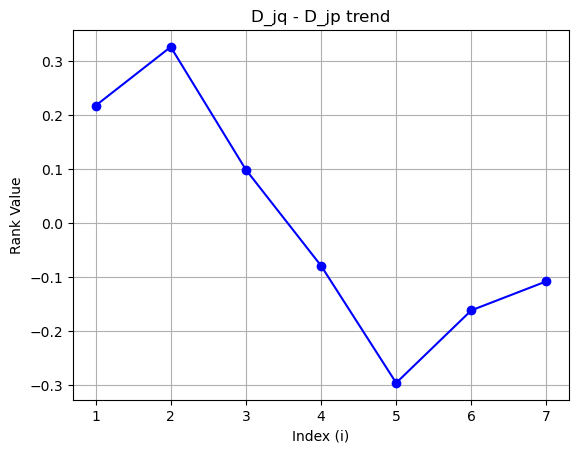

0.12406152719282186


In [84]:
import matplotlib.pyplot as plt

print(D_ij_trend_array())

array = D_ij_trend_array()

index = list(range(1,n+1))
plt.plot(index, array, marker='o', linestyle='-', color='b')
plt.title('D_jq - D_jp trend')
plt.xlabel('Index (i)')
plt.ylabel('Rank Value')
plt.grid(True)
plt.xticks(index)  # Set the ticks to match the index values
plt.show()

print( (array[1] + array[3])/2 )


In [85]:
trend2_coeff = 2 * tanh(lamb/2) / sinh(lamb*n)  

print(trend2_coeff)

0.01041730248835175


In [86]:
def D_ij_analytical_case_3c_minus_delta(i, j):
    lamb = lamb_val
    return ( ( 2 * tanh(lamb/2) * cosh((i-1/2)*lamb) * cosh((n-i+1/2)*lamb) ) / sinh(lamb*n) )

def D_ij_analytical_sol_trend2(i, j):
        if i < j:
            return D_ij_analytical_case_1b(i, j) / trend2_coeff
        elif i > j: 
            return D_ij_analytical_case_2b(i, j) / trend2_coeff
        elif i == j:
            return D_ij_analytical_case_3c_minus_delta(i, j) / trend2_coeff

def D_ij_trend2_array():        
    array = []
    for j in range (1, n+1):
        array.append(D_ij_analytical_sol_trend2(j,q) - D_ij_analytical_sol_trend2(j,p))
    return array

[20.917968749999996, 31.376953125, 9.52734375, -7.558593749999998, -28.423828125, -15.50390625, -10.3359375]


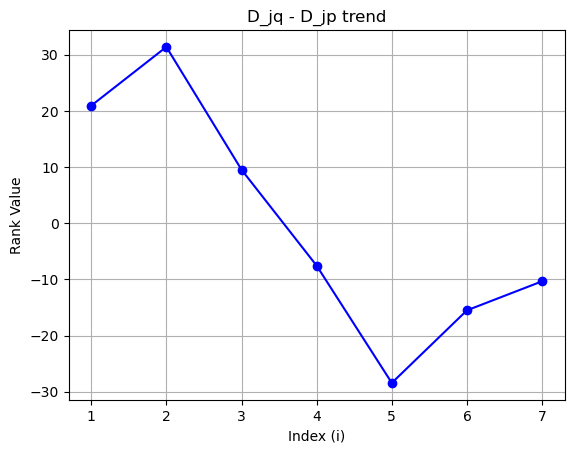

In [87]:
import matplotlib.pyplot as plt

print(D_ij_trend2_array())

array = D_ij_trend2_array()

index = list(range(1,n+1))
plt.plot(index, D_ij_trend2_array(), marker='o', linestyle='-', color='b')
plt.title('D_jq - D_jp trend')
plt.xlabel('Index (i)')
plt.ylabel('Rank Value')
plt.grid(True)
plt.xticks(index)  # Set the ticks to match the index values
plt.show()


In [88]:

def D_ij_analytical_sol_trend3(i, j):
        if i < j:
            return D_ij_analytical_case_1b(i, j)
        elif i > j: 
            return D_ij_analytical_case_2b(i, j)
        elif i == j:
            return D_ij_analytical_case_3c_minus_delta(i, j)

def D_ij_trend3_array():        
    arrayq = []
    arrayp = []
    for j in range (1, n+1):
        arrayq.append(D_ij_analytical_sol_trend3(j,q))
        arrayp.append(D_ij_analytical_sol_trend3(j,p))
    return arrayq, arrayp



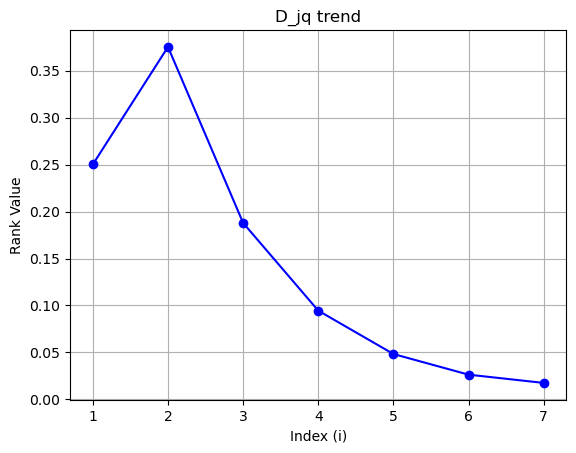

In [89]:
arrayq, arrayp = D_ij_trend3_array()

index = list(range(1,n+1))
plt.plot(index, arrayq, marker='o', linestyle='-', color='b')
plt.title('D_jq trend')
plt.xlabel('Index (i)')
plt.ylabel('Rank Value')
plt.grid(True)
plt.xticks(index)  # Set the ticks to match the index values
plt.show()

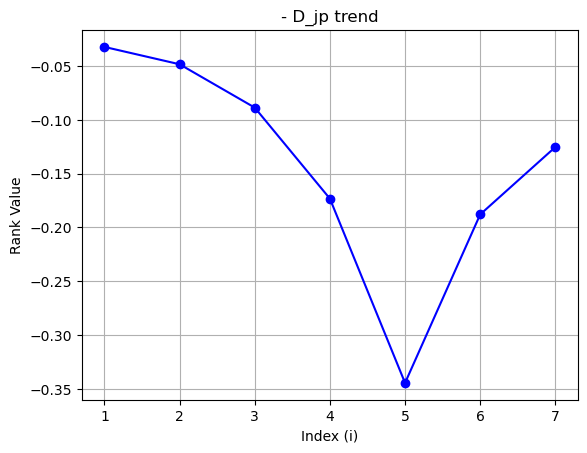

In [90]:
arrayp = -1 * np.array(arrayp)

index = list(range(1,n+1))
plt.plot(index, arrayp, marker='o', linestyle='-', color='b')
plt.title('- D_jp trend')
plt.xlabel('Index (i)')
plt.ylabel('Rank Value')
plt.grid(True)
plt.xticks(index)  # Set the ticks to match the index values
plt.show()

In [91]:
def D_ij_analytical_sol_trend4(i, j):
        if i < j:
            return D_ij_analytical_case_1b(i, j) / ( np.cosh( (i-1/2) * lamb_val ) * np.cosh( (n-(j-1/2)) * lamb_val) )
        elif i > j: 
            return D_ij_analytical_case_2b(i, j) / ( np.cosh( (j-1/2) * lamb_val ) * np.cosh( (n-(i-1/2)) * lamb_val) )
        elif i == j:
            return D_ij_analytical_case_3c_minus_delta(i, j) / ( cosh((i-1/2)*lamb) * cosh((n-i+1/2)*lamb) )

def D_ij_trend4_array():        
    array = []
    for j in range (1, n+1):
        array.append(D_ij_analytical_sol_trend4(j,q) - D_ij_analytical_sol_trend4(j,p))
    return array


[20.917968749999996, 31.376953125, 9.52734375, -7.558593749999998, -28.423828125, -15.50390625, -10.3359375]
[20.917968749999996, 31.376953125, 9.52734375, -7.558593749999998, -28.423828125, -15.50390625, -10.3359375]


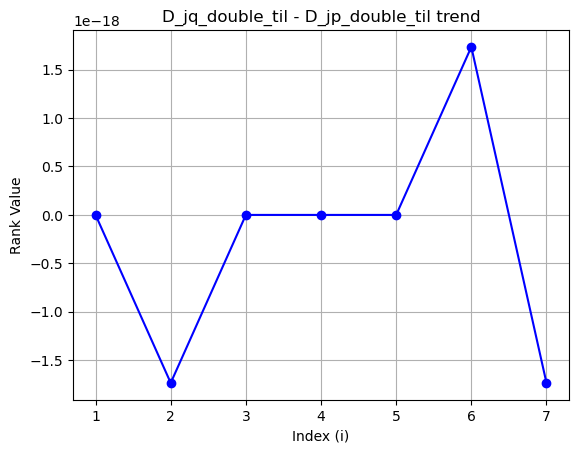

In [92]:
print(D_ij_trend_array())

array = D_ij_trend4_array()

index = list(range(1,n+1))
plt.plot(index, D_ij_trend4_array(), marker='o', linestyle='-', color='b')
plt.title('D_jq_double_til - D_jp_double_til trend')
plt.xlabel('Index (i)')
plt.ylabel('Rank Value')
plt.grid(True)
plt.xticks(index)  # Set the ticks to match the index values
plt.show()


In [93]:

def D_ij_analytical_sol_trend5(i, j):
        if i < j:
            return D_ij_analytical_case_1b(i, j) / ( np.cosh( (i-1/2) * lamb_val ) * np.cosh( (n-(j-1/2)) * lamb_val) )
        elif i > j: 
            return D_ij_analytical_case_2b(i, j) / ( np.cosh( (j-1/2) * lamb_val ) * np.cosh( (n-(i-1/2)) * lamb_val) )
        elif i == j:
            return D_ij_analytical_case_3c_minus_delta(i, j) / ( cosh((i-1/2)*lamb) * cosh((n-i+1/2)*lamb) )

def D_ij_trend5_array():        
    arrayq = []
    arrayp = []
    for j in range (1, n+1):
        arrayq.append(D_ij_analytical_sol_trend5(j,q))
        arrayp.append(D_ij_analytical_sol_trend5(j,p))
    return arrayq, arrayp



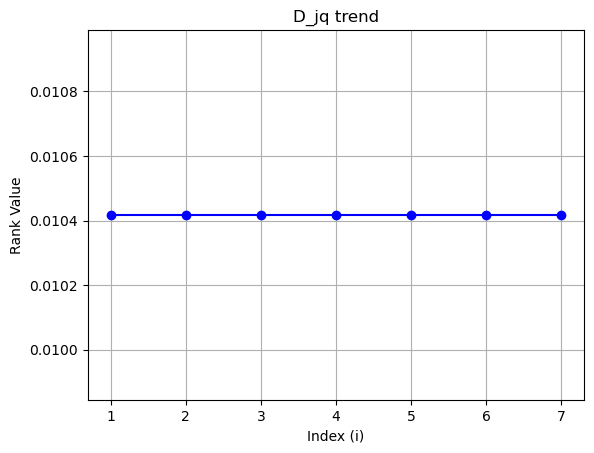

In [94]:
arrayq, arrayp = D_ij_trend5_array()

index = list(range(1,n+1))
plt.plot(index, arrayq, marker='o', linestyle='-', color='b')
plt.title('D_jq trend')
plt.xlabel('Index (i)')
plt.ylabel('Rank Value')
plt.grid(True)
plt.xticks(index)  # Set the ticks to match the index values
plt.show()

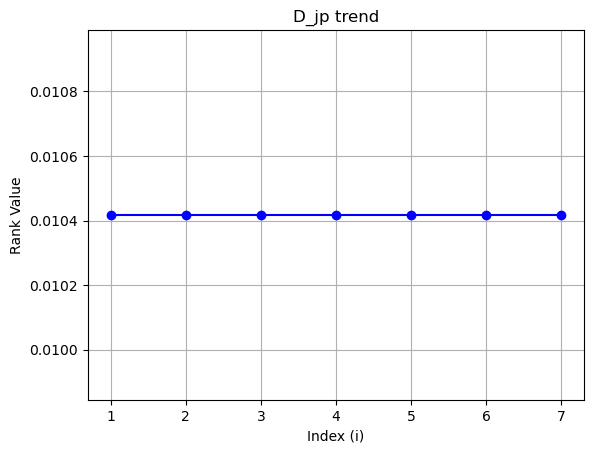

In [95]:
index = list(range(1,n+1))
plt.plot(index, arrayp, marker='o', linestyle='-', color='b')
plt.title('D_jp trend')
plt.xlabel('Index (i)')
plt.ylabel('Rank Value')
plt.grid(True)
plt.xticks(index)  # Set the ticks to match the index values
plt.show()

In [96]:
for i in range(0, n):
    print(arrayq[i])

for i in range(0, n):
    print(arrayp[i])

for i in range(0, n):
    print(arrayq[i] - arrayp[i])

0.01041730248835175
0.010417302488351748
0.01041730248835175
0.01041730248835175
0.01041730248835175
0.010417302488351751
0.01041730248835175
0.01041730248835175
0.01041730248835175
0.01041730248835175
0.01041730248835175
0.01041730248835175
0.01041730248835175
0.010417302488351751
0.0
-1.734723475976807e-18
0.0
0.0
0.0
1.734723475976807e-18
-1.734723475976807e-18


In [97]:
print(D_ij_analytical_sol_trend5(1,q))

0.01041730248835175


In [104]:

def D_ij_analytical_sol_trend7(i, j):
        if i < j:
            return np.cosh( (i-1/2) * lamb_val )
        elif i > j: 
            return np.cosh( (j-1/2) * lamb_val )
        elif i == j:
            return np.cosh( (j-1/2) * lamb_val )

def D_ij_analytical_sol_trend8(i, j):
        if i < j:
            return np.cosh( (n-(j-1/2)) * lamb_val)
        elif i > j: 
            return np.cosh( (n-(i-1/2)) * lamb_val)
        elif i == j:
            return np.cosh( (n-(i-1/2)) * lamb_val)


def D_ij_trend78_array():        
    arrayterm1q = []
    arrayterm2q = []
    arrayterm1p = []
    arrayterm2p = []
    for j in range (1, n+1):
        arrayterm1q.append(D_ij_analytical_sol_trend7(j,q))
        arrayterm2q.append(D_ij_analytical_sol_trend8(j,q))
        arrayterm1p.append(D_ij_analytical_sol_trend7(j,p))
        arrayterm2p.append(D_ij_analytical_sol_trend8(j,p))
    return arrayterm1q, arrayterm2q, arrayterm1p, arrayterm2p



In [99]:
print(lamb)

0.6931471805599453


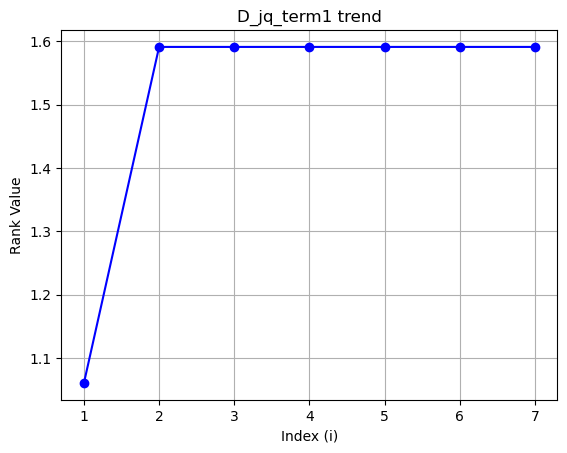

In [105]:
arrayterm1q, arrayterm2q, arrayterm1p, arrayterm2p = D_ij_trend78_array()

index = list(range(1,n+1))
plt.plot(index, arrayterm1q, marker='o', linestyle='-', color='b')
plt.title('D_jq_term1 trend')
plt.xlabel('Index (i)')
plt.ylabel('Rank Value')
plt.grid(True)
plt.xticks(index)  # Set the ticks to match the index values
plt.show()

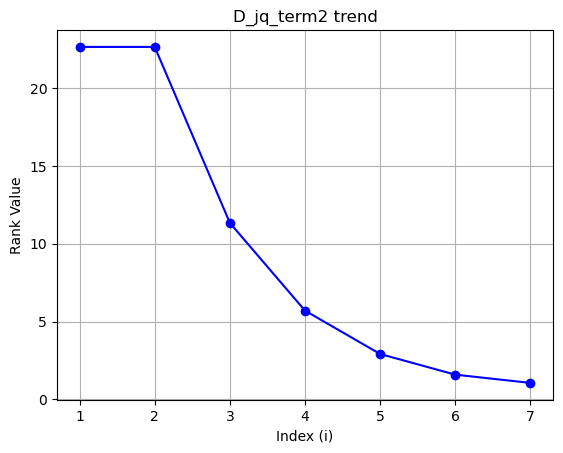

: 

In [106]:
index = list(range(1,n+1))
plt.plot(index, arrayterm2q, marker='o', linestyle='-', color='b')
plt.title('D_jq_term2 trend')
plt.xlabel('Index (i)')
plt.ylabel('Rank Value')
plt.grid(True)
plt.xticks(index)  # Set the ticks to match the index values
plt.show()

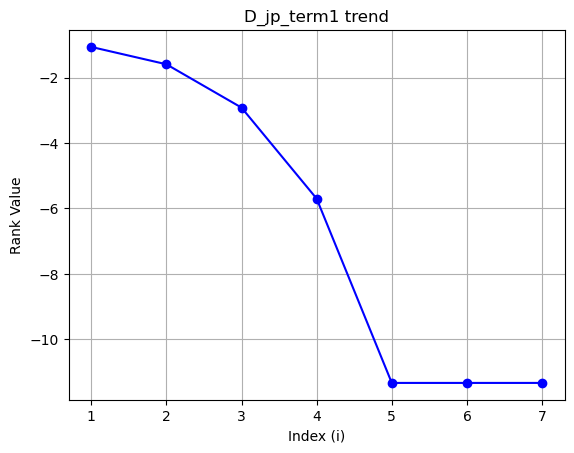

In [102]:
arrayterm1p = -1 * np.array(arrayterm1p)

index = list(range(1,n+1))
plt.plot(index, arrayterm1p, marker='o', linestyle='-', color='b')
plt.title('D_jp_term1 trend')
plt.xlabel('Index (i)')
plt.ylabel('Rank Value')
plt.grid(True)
plt.xticks(index)  # Set the ticks to match the index values
plt.show()

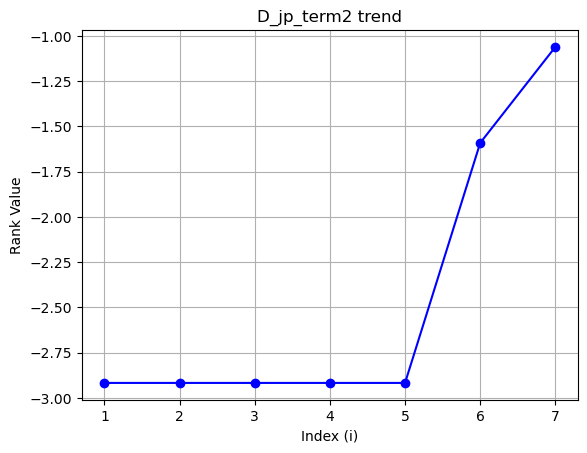

In [103]:
arrayterm2p = -1 * np.array(arrayterm2p)

index = list(range(1,n+1))
plt.plot(index, arrayterm2p, marker='o', linestyle='-', color='b')
plt.title('D_jp_term2 trend')
plt.xlabel('Index (i)')
plt.ylabel('Rank Value')
plt.grid(True)
plt.xticks(index)  # Set the ticks to match the index values
plt.show()